### Example with simpy and graphs
The cel below imports the libraries we require.

In [16]:
import simpy            # Used for simulation
import math             # Used for mathematical functions

import networkx as nx   # Used for making the graph to visualize our problem

The cel below visualizes the problem. In graph theory the red dots are called *edges* and the lines are called *vertices*. Vessels (or any other object) move from edge 1 to edge 3 and from edge 4 to edge 2. The added complexity is that vertice 5-6 only allows traffic in one direction at a time. Vessels can travel simultanously in one direction.

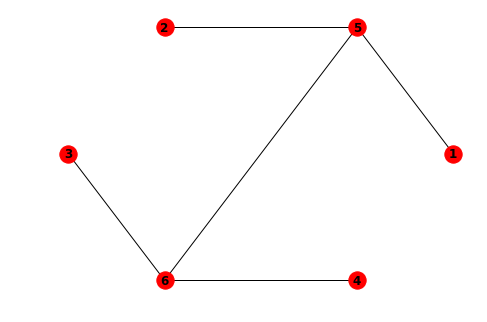

In [17]:
FG = nx.Graph()
FG.add_edges_from([(1, 5), (2, 5), (3, 6), (4, 6), (5, 6)])
nx.draw_shell(FG, with_labels=True, font_weight='bold')

### Make classes

In [18]:
class edge(object):
    """Every edge has a location"""
    
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y

In [19]:
class vertice(object):
    """Every edge is connected to another node via a vertice"""
    
    def __init__(self, env, edge_1, edge_2, resources=10, pass_limits=False):
        self.env = env
        self.edge_1 = edge_1
        self.edge_2 = edge_2
        self.distance = math.sqrt((edge_1.x - edge_2.x) ** 2 + (edge_1.y - edge_2.y) ** 2)
        self.resources = simpy.Resource(env, resources)
        
        if pass_limits == True:
            self.pass_limits = simpy.Resource(env, 1)
            self.pass_direction = None
        else:
            self.pass_limits = False
            self.pass_direction = None
    
    def pass_vertice(self, traveller, from_edge, to_edge):
        """To pass a vertice you have to travel and check whether passing is possible.
        
        If traffic is one-way, this should be checked.
        """
        if (from_edge != self.edge_1 and from_edge != self.edge_2) or \
           (to_edge != self.edge_1 and to_edge != self.edge_2):
            print("BREAK THE FUNCTION")
            
        if self.pass_direction == "{} to {}".format(from_edge, to_edge) or self.pass_limits == False:
            print("{} - {} has passed edge {} and is now at edge {}.".format(self.env.now, traveller.name, from_edge.name, to_edge.name))

            yield self.env.timeout(self.distance / traveller.speed)
            traveller.location = to_edge
            traveller.log_entry("Passed vertice", to_edge, self.env.now)
        
        else:
            arrive = self.env.now
            with self.pass_limits.request() as request:
                yield request
                
                print("")
                print("Traffic now moves from {} to {}".format(from_edge.name, to_edge.name))
                print("{} - {} has passed edge {} and is now at edge {}.".format(self.env.now, traveller.name, from_edge.name, to_edge.name))
                
                if arrive != self.env.now:
                    traveller.log_entry("Waiting to pass vertice", to_edge, self.env.now)
                
                yield self.env.timeout(self.distance / traveller.speed)
                traveller.location = to_edge
                traveller.log_entry("Passed vertice", to_edge, self.env.now)

In [20]:
class vessel(object):
    """Vessels are the objects that move over the vertices"""
    
    def __init__(self, env, name, speed, origin, destination, path):
        self.env = env
        self.name = name
        self.speed = speed
        self.location = origin
        self.destination = destination
        self.path = path 
        
        self.log = []
        self.loc = []
        self.t = []
        
    def move(self, vertice):
        """Move from one edge to another, passing a vertice"""
        if self.location == vertice.edge_1:
                local_destination = vertice.edge_2
        else:
            local_destination = vertice.edge_1

        with vertice.resources.request() as request:
            yield request
        
            yield from vertice.pass_vertice(self, self.location, local_destination)
    
    def log_entry(self, log, location, t):
        """Logging the information"""
        self.log.append(log)
        self.loc.append(location)
        self.t.append(t)

In [21]:
def start(env, vessel):
    for vertice in vessel.path:
        yield from vessel.move(vertice)
        
        if vessel.location == vessel.destination:
            break

### Define environment

In [22]:
env = simpy.Environment()

In [23]:
edge_1 = edge("1", 0, 2)
edge_2 = edge("2", 3, 2)
edge_3 = edge("3", 0, 0)
edge_4 = edge("4", 3, 0)
edge_5 = edge("5", 1, 1)
edge_6 = edge("6", 2, 1)

In [24]:
vertice_1_5 = vertice(env, edge_1, edge_5)
vertice_2_6 = vertice(env, edge_2, edge_6)
vertice_3_5 = vertice(env, edge_3, edge_5)
vertice_4_6 = vertice(env, edge_4, edge_6)
vertice_5_6 = vertice(env, edge_5, edge_6, pass_limits = True)

In [25]:
path_1 = [vertice_1_5, vertice_5_6, vertice_2_6]
path_2 = [vertice_4_6, vertice_5_6, vertice_3_5]

In [26]:
vessel_1 = vessel(env, "Vessel 1", 3, edge_1, edge_2, path_1)
vessel_2 = vessel(env, "Vessel 2", 3, edge_4, edge_3, path_2)

### Run simulation

In [27]:
env.process(start(env, vessel_1))
env.process(start(env, vessel_2))

env.run()

0 - Vessel 1 has passed edge 1 and is now at edge 5.
0 - Vessel 2 has passed edge 4 and is now at edge 6.

Traffic now moves from 5 to 6
0.47140452079103173 - Vessel 1 has passed edge 5 and is now at edge 6.
0.804737854124365 - Vessel 1 has passed edge 6 and is now at edge 2.

Traffic now moves from 6 to 5
0.804737854124365 - Vessel 2 has passed edge 6 and is now at edge 5.
1.1380711874576983 - Vessel 2 has passed edge 5 and is now at edge 3.


In [28]:
for i in range(len(vessel_1.log)):
    print(vessel_1.log[i], vessel_1.t[i])

Passed vertice 0.47140452079103173
Passed vertice 0.804737854124365
Passed vertice 1.2761423749153968


In [29]:
for i in range(len(vessel_2.log)):
    print(vessel_2.log[i], vessel_2.t[i])

Passed vertice 0.47140452079103173
Waiting to pass vertice 0.804737854124365
Passed vertice 1.1380711874576983
Passed vertice 1.60947570824873
